In [ ]:
import os
import json
import torch
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
from tqdm import tqdm
from sklearn import svm
from pathlib import Path
from sklearn.model_selection import KFold
from transformers import AutoImageProcessor, AutoModel
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix,ConfusionMatrixDisplay,classification_report

In [ ]:
def create_list(dir,isImage=True,sort=False,fullPath=False):
  """
  Create list given directory.
  """
  lst = os.listdir(dir)

  if sort:
    lst = sort_list(lst,isImage)

  if fullPath:
    for i,img in enumerate(lst):
      path = os.path.join(dir,img)
      lst[i] = path

  return lst

## To manipulate data.
def sort_list(lst,isImage:bool=True):
  """
  Sort given list
  isImage used to check for images list or json list is given.
  """
  if not isImage:
    s = 5
  else:
    s = 4
  new_lst = []
  extensions = {}
  for i in range(0,len(lst)):
    id = Path(lst[i]).stem
    extensions[id] = lst[i][-s:]
    new_lst.append(int(id))

  new_lst = sorted(new_lst)

  for i in range(0,len(lst)):
    id = str(new_lst[i])
    new_lst[i]= id + extensions[id]
  return new_lst

def create_dict(keys,values):
  """
  Return created dictionary.
  """
  dictionary = {}
  for i,k in enumerate(keys):
    dictionary[k] = values[i]
  return dictionary

def create_img_label_dict(imgs_lst,labels_lst,column_num:int):
  """
  create dictionary with images as keys and excel labels as values.
  Image list must be sorted before call this function.
  For sorting call sort_image_list function before.
  """
  _dict = {}
  for i,img in enumerate(imgs_lst):
    _dict[img] = labels_lst.iloc[i,column_num]
  return _dict

def display_images_labels(imgs_lst,image_label_dictionary):
  """
  Return dataframe contains images and corresponding labels.
  """
  return pd.DataFrame({
      "Image" : [img for img in imgs_lst],
      "Label" : [image_label_dictionary[img] for img in imgs_lst]
  })

def get_selected_indexes(indexs:list,elements_list:list):
  """
  Get elements from elemnts list given their indexs.
  """
  arr = []
  for idx in indexs:
    arr.append(elements_list[idx])
  return arr

def get_values(keys,dictionary):
  """
  Given  keys, returns values from dictionary.
  """
  arr = []
  for key in keys:
    arr.append(dictionary[key])
  return arr

## For controls.
def search(arr,start_index,element):
  """
  Search for elemnt in given Arrays.
  If found returns searched element, else returns -1.
  """
  if element ==-1:
    j=start_index+1
    element = arr[start_index]
  else:
    j=0
  while j<len(arr):
    if element == arr[j]:
      return element
    else:
      j+=1
  return -1

def getNotFoundElements(arr1,arr2):
  """
  Given aar1, returns elements that not found in arr2.
  """
  not_found= []
  for elm in arr1:
    xx = search(arr2,-1,elm)
    if xx ==-1:
      not_found.append(elm)
  return not_found

def create_cm(actual_labels,predicted,classes,title="Confusion Matrix"):
  """
  Create Confusion Matrix.
  """
  cm = confusion_matrix(actual_labels, predicted)
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  cm_display.plot()
  plt.title(title)
  plt.show()

def calculate_metrics(labels,predictions):
  precision = precision_score(labels,predictions)
  recall = recall_score(labels,predictions)
  accuracy = accuracy_score(labels,predictions)
  return accuracy, precision, recall

In [ ]:
def load_image(file_name):
  path = "/content/drive/MyDrive/Ara_proje_dataset/masks/"
  image_path = path + file_name
  image = Image.open(image_path).convert('RGB')
  return image

def preprocessImage(file_name,transform):
  path = "/content/drive/MyDrive/Ara_proje_dataset/masks/"
  image_path = path + file_name
  image = Image.open(image_path).convert('RGB')
  return transform(image).unsqueeze(0)

def compute_embeddings(images,device,model,transform):
  all_embeddings = {}
  with torch.no_grad():
    for i, img in enumerate(tqdm(images,desc="Processing files")):
      input = preprocessImage(img,transform).to(device)
      output = model(input)
      embeddings = output.last_hidden_state.mean(dim=1)
      all_embeddings[img] = np.array(embeddings[0].cpu().numpy()).tolist()

  return all_embeddings

def test_model(images,img_lbl_dict,embeddings,classes,model):
  embeddings = get_values(images,embeddings)
  embeddings_list = np.array(list(embeddings))
  with torch.no_grad():
    predictions = model.predict(embeddings_list)
    labels = get_values(images,img_lbl_dict)
    res = calculate_metrics(labels,predictions)
    print(f"Accuracy: {res[0]}, Precision: {res[1]}, Recall: {res[2]}")
    create_cm(labels,predictions,classes)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_processor = AutoImageProcessor.from_pretrained('facebook/deit-base-distilled-patch16-224')
deit = AutoModel.from_pretrained('facebook/deit-base-distilled-patch16-224').to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/349M [00:00<?, ?B/s]

Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['deit.pooler.dense.bias', 'deit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
images_dir = "/content/drive/MyDrive/Ara_proje_dataset/masks"
excel_path = "/content/drive/MyDrive/Ara_proje_dataset/Total_Excel.xlsx"
classes = ("Hatasiz" , "Hatali")
transform = T.Compose([T.Resize((224,224)),T.ToTensor(),T.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)])

labels = pd.read_excel(excel_path,header=None,keep_default_na=False)
images = create_list(images_dir,sort=True)
img_lbl_dict = create_img_label_dict(images,labels,column_num=1)
print("labels file length =", len(labels))
print("images list length =", len(images))
print("dictionary  length =", len(img_lbl_dict))
display_images_labels(images,img_lbl_dict)

labels file length = 1497
images list length = 1497
dictionary  length = 1497


,Image,Label
0,1.jpg,0
1,2.jpg,1
2,3.jpg,1
3,4.jpg,0
4,5.jpg,1
...,...,...
1492,3554.bmp,1
1493,3555.bmp,0
1494,3556.bmp,0
1495,3557.bmp,0


In [ ]:
embeddings = compute_embeddings(images,device,deit,transform)

Processing files: 100%|██████████| 1497/1497 [04:31<00:00,  5.52it/s]


In [ ]:
with open("/content/drive/MyDrive/Models/DeiT_Embs_mandibular.json", "w") as f:
  f.write(json.dumps(embeddings))

In [ ]:
clf = svm.SVC(probability=True,gamma='scale')               ## Initialize classifier
K = 5                                                       ## Number of folds
kf = KFold(n_splits=K)                                      ## Define K-Fold method for cross validation

In [ ]:
## Train loop
metrics = []
predicted_lbls = []
actual_lbls = []
prev_acc = 0.0
for i, (train_index, test_index) in enumerate(kf.split(images)):
  print(f"Fold {i+1}/{K}")
  ## Get select images for train/test folds.
  x_train = get_selected_indexes(train_index,images)
  x_test  = get_selected_indexes(test_index,images)

  ## get embedding values from embeddings dictionary.
  train_emb = get_values(x_train,embeddings)
  test_emb = get_values(x_test,embeddings)

  ## Convert embeddings to numby array.
  train_emb_list = np.array(train_emb)
  test_emb_list = np.array(test_emb)
  ## Get corresponding labels.
  y_train = get_values(x_train,img_lbl_dict)
  y_test = get_values(x_test,img_lbl_dict)

  model = clf.fit(train_emb_list,y_train)
  predictions = model.predict(test_emb_list)

  predicted_lbls.extend(predictions)
  actual_lbls.extend(y_test)
  res = calculate_metrics(y_test,predictions)
  if prev_acc < res[0]:
    with open('best_model.pkl', 'wb') as f:
      pickle.dump(model, f)
    prev_acc = res[0]

  print(f"Accuracy: {res[0]}, Precision: {res[1]}, Recall: {res[2]}")
  metrics.append(res)

Fold 1/5
Accuracy: 0.5566666666666666, Precision: 0.48466257668711654, Recall: 0.6171875
Fold 2/5
Accuracy: 0.62, Precision: 0.6040268456375839, Recall: 0.6206896551724138
Fold 3/5
Accuracy: 0.68561872909699, Precision: 0.7524752475247525, Recall: 0.7755102040816326
Fold 4/5
Accuracy: 0.5083612040133779, Precision: 0.48936170212765956, Recall: 0.9787234042553191
Fold 5/5
Accuracy: 0.6354515050167224, Precision: 0.7485714285714286, Recall: 0.6683673469387755


Average Accuracy : 60.12196209587514
Average Precision 61.58195601097083
Average Recall 73.20956220896281


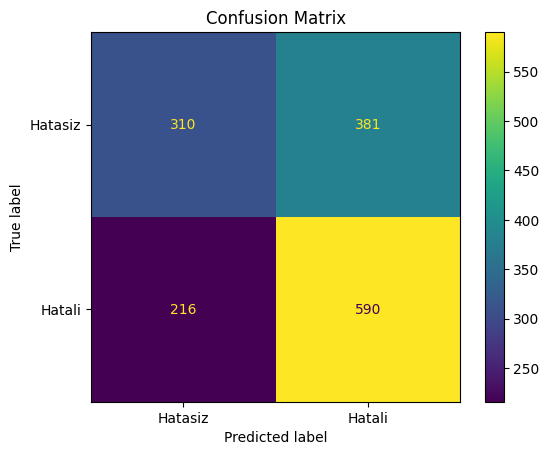

In [ ]:
avg_acc, avg_precision, avg_recall= 0.0, 0.0, 0.0
acc = []
for i in range(K):
    avg_acc += metrics[i][0]
    acc.append(metrics[i][0])
    avg_precision += metrics[i][1]
    avg_recall += metrics[i][2]

avg_acc = 100*avg_acc/K
avg_precision = 100*avg_precision/K
avg_recall = 100*avg_recall/K

## Print Train metrics results
print("Average Accuracy :", avg_acc)
print("Average Precision", avg_precision)
print("Average Recall", avg_recall)

## Draw confusion matrix
create_cm(actual_lbls,predicted_lbls,classes)

Accuracy: 0.6526386105544422, Precision: 0.6574889867841409, Recall: 0.7406947890818859


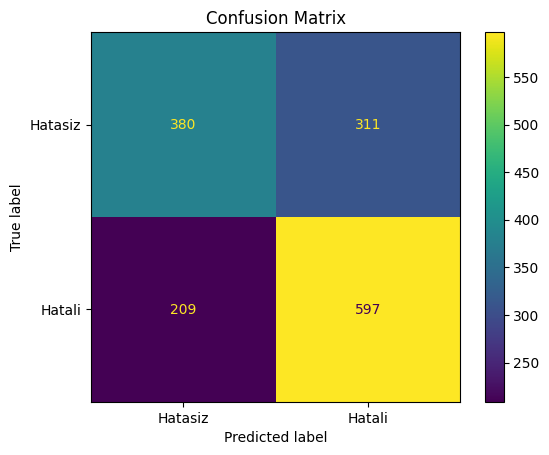

In [ ]:
## Test best model
with open('best_model.pkl', 'rb') as f:
    best_model = pickle.load(f)
test_model(images,img_lbl_dict,embeddings,classes,best_model)

In [ ]:
with open('/content/drive/MyDrive/Models/DeiTbest_model_mandibular.pkl', 'wb') as f:
  pickle.dump(best_model, f)